# Setup and import data

In [45]:
# Imports and Setup
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
# Read data

# Data is in this directory
# working_dir = os.path.join('/','Users','greg','Working','GTEnergy')
working_dir = os.getcwd()

# Data is in two files, one for the account data (acct #, meter, location)
# and the other is for the billing data. Both have a common bill_id column
acct_data_fname = os.path.join(working_dir, 'account_data.csv')
bill_data_fname = os.path.join(working_dir, 'bill_data.csv')

# For now, don't do any indexing. This may change if things get convoluted
acct_data = pd.read_csv(acct_data_fname,sep=',',index_col=False)
bill_data = pd.read_csv(bill_data_fname,sep=',',index_col=False)

# Note: to map bill_id to a building with multiple meters, do int(bill_id/100)
# to get the building number (i.e. take off two right digits)

# Add a column with YYYYMM for grouping by month later on
bill_data['ts'] = pd.DatetimeIndex(bill_data['date']).month.astype(str)
bill_data['ts'] = pd.DatetimeIndex(bill_data['date']).year.astype(str) + '-' + bill_data.ts.apply('{:0>2}'.format)

In [4]:
# Translate bill ID to location
def id2loc(id,short=False):

    bldg_txt = acct_data[acct_data.bill_id==id].building.values[0]
    bldg_txt = bldg_txt if short else str(id)+' - '+bldg_txt    

    addr_txt = acct_data[acct_data.bill_id==id].location.values[0]
    addr_txt = '' if short else ' - '+addr_txt    
    
    meter_txt = acct_data[acct_data.bill_id==id].meter.values[0]
    meter_txt = '' if meter_txt is np.NAN else ': '+meter_txt

    location = (bldg_txt + addr_txt + meter_txt )
    return location

In [5]:
## Plot and stat functions

# Plot columns for a given bill_id
def plot_cols(df, id, cols, dt='ts'):
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    for col in cols:
        df[df.bill_id==id].plot(x=dt, y=col, ax=ax)
    plt.title(id2loc(id))  
    
    return fig, ax

# Plot all column value for all bill IDs
def plot_all_bills(df, colname, title=None):

    title = colname if title is None else title
    
    number_of_plots=len(df.bill_id.unique())
    colormap = plt.cm.nipy_spectral
    colors = sns.color_palette("hls", number_of_plots)
    
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    ax.set_prop_cycle('color', colors)
    
    df.groupby("bill_id").plot(x="ts", y=colname, ax=ax)
    
    plt.title(title+' per bill ID')
    plt.legend([id2loc(v[0]) for v in df.groupby('bill_id')['bill_id']])  

    return fig, ax
    
# Basic stats
def basic_stats(df,id,cols):
    
    stats = df[df.bill_id==id][cols].describe()
    
    return stats

# Plot stuff and see stats

## Some basic data checking

11
7


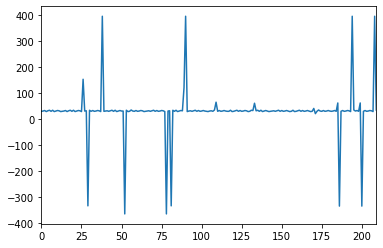

In [82]:
bill_data['num_days'] = pd.DatetimeIndex(bill_data['date']) - pd.DatetimeIndex(bill_data['last_date'])
bill_data.num_days = bill_data.num_days.dt.days

lower_limit = 365.0/12 - 7
upper_limit = 365.0/12 + 7

print(len(bill_data[(bill_data.num_days > upper_limit)]))
print(len(bill_data[(bill_data.num_days < lower_limit)]))

bill_data.num_days.plot()

## Totals and breakout useage and costs

### Total gas & electic costs for town

Text(0.5, 0, 'Billing date')

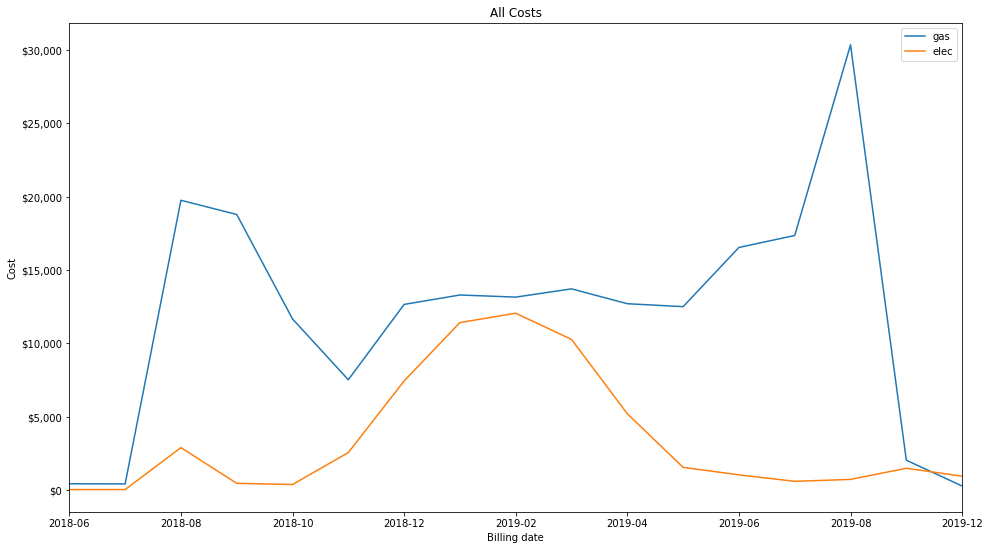

In [6]:
# Total gas and electric costs for town

fig, ax = plt.subplots(1,1, figsize=(16,9))

bill_data.groupby('ts').apply(lambda row: row.elec_total.sum()).plot(ax=ax)
bill_data.groupby('ts').apply(lambda row: row.gas_total.sum()).plot(ax=ax)
plt.legend(['gas','elec'])
plt.title('All Costs')

# Customize
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,g}'))
ax.set_ylabel('Cost')
ax.set_xlabel('Billing date')

Text(0.5, 0, 'Billing date')

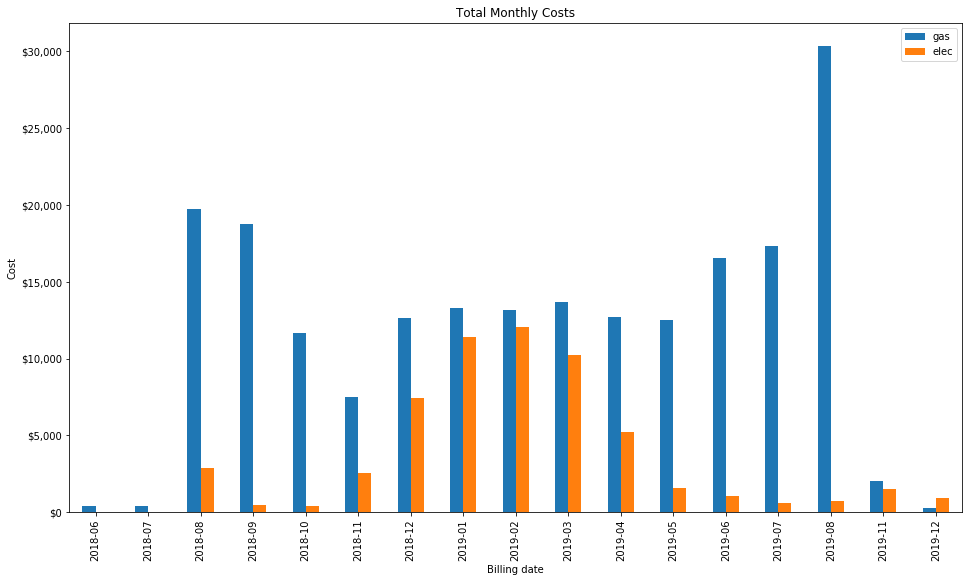

In [7]:
# Same as above, but bar graph. Non quantitavie people like bar graphs
columns = ['gas_therms', 'gas_delivery', 'gas_supply', 'gas_total',
           'elec_kWh', 'elec_delivery', 'elec_supply', 'elec_total']

tot_df = pd.DataFrame()
for col in columns:
    tot_df[col] = bill_data.groupby('ts').apply(lambda row: row[col].sum())

fig, ax = plt.subplots(1,1, figsize=(16,9))

tot_df[['elec_total','gas_total']].plot.bar(ax=ax)
plt.legend(['gas','elec'])
plt.title('Total Monthly Costs')

# Customize
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,g}'))
ax.set_ylabel('Cost')
ax.set_xlabel('Billing date')

### Gas & electic usage breakdown

Text(0.5, 0, 'Billing date')

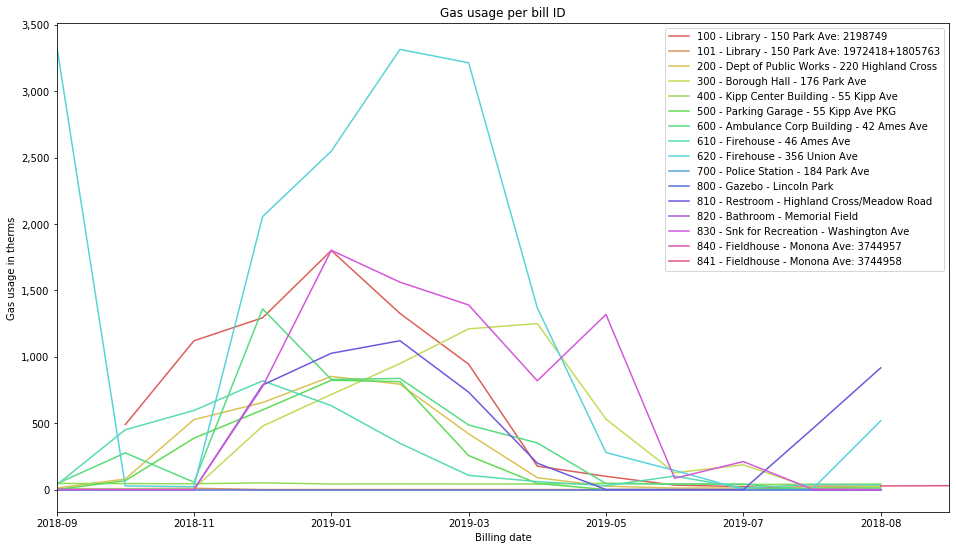

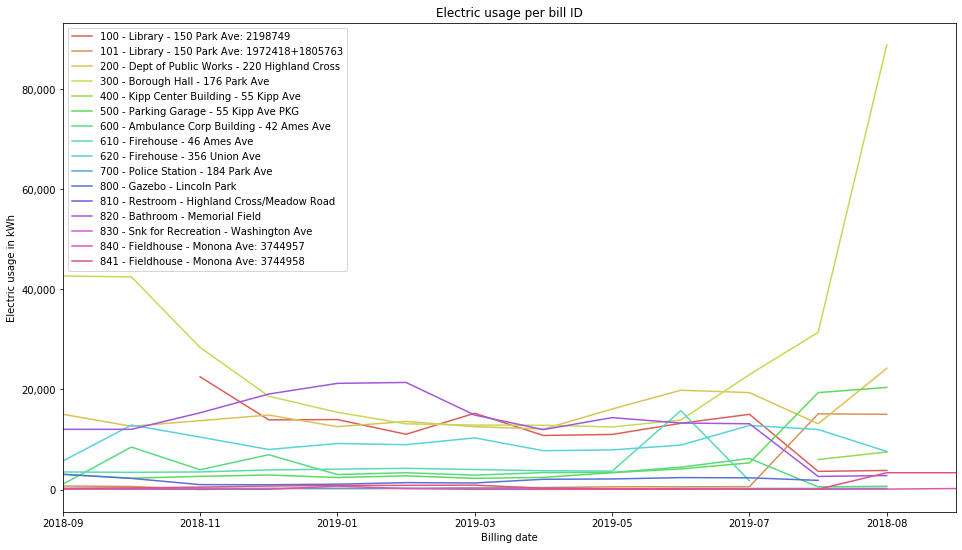

In [8]:
# see gas and electric usage for each bill_id

# Call plots
_fig, ax1 = plot_all_bills(bill_data, 'gas_therms', 'Gas usage')
_fig, ax2 = plot_all_bills(bill_data, 'elec_kWh', 'Electric usage')

# Customize
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.set_ylabel('Gas usage in therms')
ax1.set_xlabel('Billing date')
# 
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylabel('Electric usage in kWh')
ax2.set_xlabel('Billing date')

## Cost and usage for a single account/meter

In [9]:
# Show bill_id and locations if needed
acct_data[['bill_id','building','location']]

,bill_id,building,location
0,100,Library,150 Park Ave
1,101,Library,150 Park Ave
2,200,Dept of Public Works,220 Highland Cross
3,300,Borough Hall,176 Park Ave
4,400,Kipp Center Building,55 Kipp Ave
5,500,Parking Garage,55 Kipp Ave PKG
6,600,Ambulance Corp Building,42 Ames Ave
7,610,Firehouse,46 Ames Ave
8,620,Firehouse,356 Union Ave
9,700,Police Station,184 Park Ave


In [12]:
bill_id = 300 # Set id for below plots/stats

Showing data for 300 - Borough Hall - 176 Park Ave
------------------------------------------------------------
       gas_delivery  gas_supply    gas_total  elec_delivery   elec_supply  \
count     13.000000   13.000000    13.000000      13.000000     13.000000   
mean     174.370769  250.294615   424.665385    1482.271538   3293.577692   
std      185.442451  287.697876   471.588607    1467.865633   2083.666682   
min       13.630000    2.790000    16.420000     610.620000   2096.010000   
25%       18.430000    5.240000    23.670000     631.910000   2535.850000   
50%       68.800000   95.570000   164.370000     838.290000   2601.480000   
75%      278.740000  429.850000   708.590000    1960.930000   3317.950000   
max      513.150000  738.410000  1235.740000    5970.090000  10049.790000   

         elec_total  
count     13.000000  
mean    4775.849231  
std     3531.334342  
min     2738.330000  
25%     3151.840000  
50%     3368.590000  
75%     5278.880000  
max    16019.88000

Text(0.5, 0, 'Billing date')

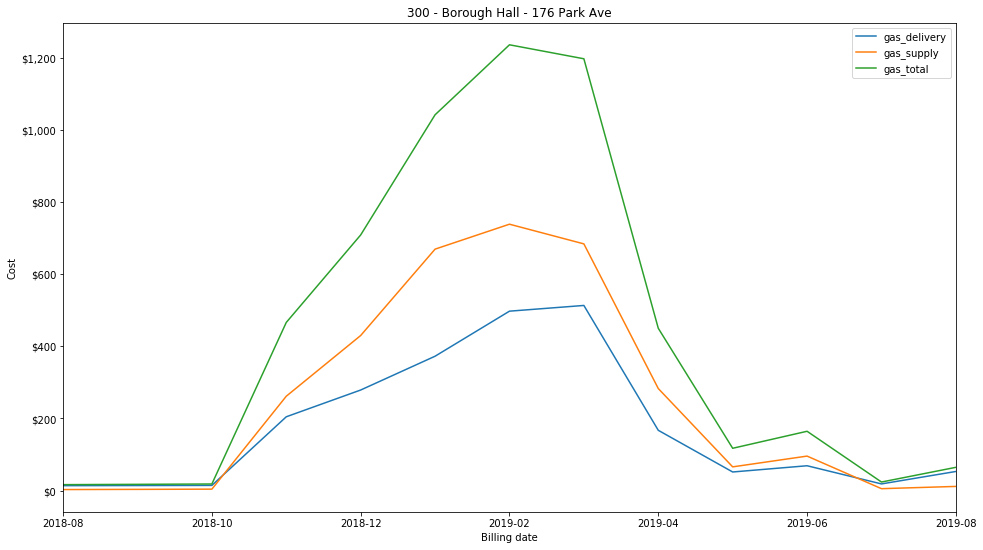

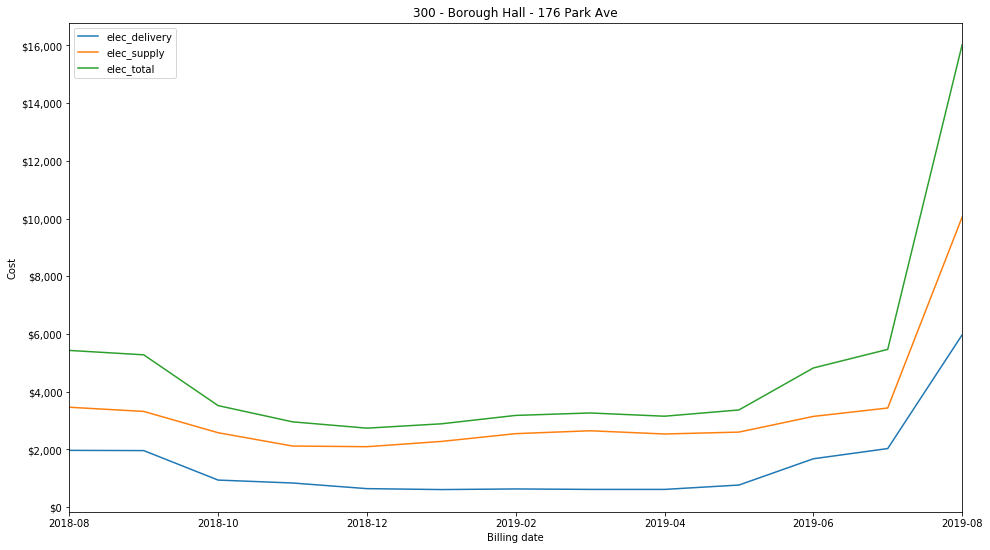

In [13]:
# For a set bill_id, show delivery and supply costs for gas & elec
# Show plots and stats

print('Showing data for '+id2loc(bill_id))
print('------------------------------------------------------------')

# Basic stats
gas_stats = ['gas_delivery','gas_supply','gas_total']
ele_stats = ['elec_delivery','elec_supply','elec_total']
stat_cols = gas_stats + ele_stats
print(basic_stats(bill_data,bill_id,stat_cols))

# Plot costs
_fig, ax1 = plot_cols(bill_data, bill_id, gas_stats)
_fig, ax2 = plot_cols(bill_data, bill_id, ele_stats)

# Customize
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,g}'))
ax1.set_ylabel('Cost')
ax1.set_xlabel('Billing date')

ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,g}'))
ax2.set_ylabel('Cost')
ax2.set_xlabel('Billing date')